In [1]:
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
%matplotlib inline

Given the equation set that describes mixed layer with stratocumulus cloud on the top:

$$
\begin{cases} 
\displaystyle\frac{dz_i}{dt} = w_e - D\cdot z_i\\
\displaystyle z_i\frac{dq_l}{dt} = C_D\left|U\right|\Delta q_0 + w_e\Delta q \\
\displaystyle z_i\frac{d\theta_l}{dt} = C_D\left|U\right|\Delta\theta_0 + w_e\Delta\theta + \frac{1}{c_p\rho}dF_l \\
\end{cases} 
$$

where $z_i$ is the mix layer height; $q_l$ and $\theta_l$ are specific humidity and temperature in the mix layer; $C_D$ is the drag coefficient; $D$ is the large scale divergence; $U$ is the mix layer wind speed; $w_e$ is the entrainment rate; $dF_l$ is the radiative cooling. The $\Delta$ terms are defined as follows:

$$
\Delta q = q_t - q_l;\qquad \Delta\theta = \theta_t - \theta_l;
\qquad \Delta q_0 = q_0 - q_l;\qquad \Delta\theta_0 = \theta_0 - \theta_l
$$

Apply different entrainment paramterizations, analyze the result.

In [2]:
# ATSC500 thermo functions [https://github.com/phaustin/atsc500/tree/master/a500]
from a500.thermo import thermfuncs as tf

def hydrostat_P(height, P0, height0=8000):
    """
    Height - pressure relation in hydrostatic state 
    """
    return P0*np.exp(-1*height/height0)

def hydrostat_H(P, P0, height0=8000):
    return height0*np.log(P0/P)

def T_ft(ML_height, gamma):
    '''
    Calculate the potential temperature at 
    the bottom of free troposphere
    '''
    return 292.0 + ML_height*gamma

def SQ(T, P):
    '''
    Calculate saturated specific humidity (Qs) 
    with given temperature and pressure 
    '''
    Rd = 287.04
    Rw = 461.50
    Tc = T - 273.15
    SVP = 6.112*np.exp(17.67*Tc/(Tc+243.5))
    SMR = (Rd/Rw)*SVP/(P - SVP)
    return SMR/(1+SMR)

def ML_model(ML_vars, Xtime, U, T0, P0, Q0, Qft, gamma, dFl, Cdrag, Cdiv, param='Moeng'):
    # Initialization
    dvars = [0, 0, 0]
    T_ml = ML_vars[0]
    Q_ml = ML_vars[1]
    ML_height = ML_vars[2]
    rho = 1.0; Cp = 1004.0
    dT = T_ft(ML_height, gamma) - T_ml
    dQ = Qft - Q_ml
    dT0 = T0 - T_ml
    dQ0 = Q0 - Q_ml
    Term1_T = U*Cdrag*dT0
    Term1_Q = U*Cdrag*dQ0
    Term3_T = dFl/Cp/rho
    # entrainment closure
    if param == 'Moeng':
        We = Moeng(Q_ml, ML_height, Term1_T, dT, k=0.23, bm=0.03)
    elif param == 'NT':
        We = Nicholls_Turton(dT, dFl, eta=0.8)
    elif param == 'Gesso':
        We = Gesso(T_ml, Q_ml, ML_height, T0, P0, Qft, gamma, dT, dQ, Term1_T, Term1_Q)
    Wh = -1*Cdiv*ML_height
    Term2_T = We*dT
    Term2_Q = We*dQ
    dvars[0] = (Term1_T + Term2_T + Term3_T)/ML_height
    dvars[1] = (Term1_Q + Term2_Q)/ML_height
    dvars[2] = Wh + We
    return dvars

def Moeng(Q_ml, ML_height, Term1_T, dT, k=0.23, bm=0.03):
    '''
    Moeng entrainment parameterization, see Moeng [2000] 
    '''
    rho = 1.0; LWP = rho*Q_ml*ML_height
    return (k*Term1_T+(2.5 - 2*np.exp(bm*np.sqrt(LWP))))/dT 

def Nicholls_Turton(dT, dFl, eta=0.8):
    """
    Nicholls-Turton entrainment parameterization
    """
    Cp = 1004.0
    return -1*eta*dFl/(Cp*dT)

def Gesso(T_ml, Q_ml, ML_height, T0, P0, Qft, gamma, dT, dQ, Term1_T, Term1_Q):
    """
    Gesso et al. [2014]
    """
    Cp = 1004.0; rho = 1.0
    Rv = 461.50; Rd = 287.04
    Tft = dT + T_ml
    LTS = Tft + gamma*(3e3-ML_height) - T0
    Pft = hydrostat_P(ML_height, P0)
    invert = tf.t_uos_thetal(T_ml, Q_ml, Pft/10) # hPa to kPa
    Tmax = invert.temp; Qmax = invert.ql
    # flux constants
    Ad, Bd, issat = tf.calc_ABcoeffs(Tft, Qft, Pft/10)
    Aw, Bw, issat = tf.calc_ABcoeffs(T_ml, Q_ml, Pft/10)
    #
    Lv = tf.L_t(Tmax)
    Cl = (Ad*Lv/Cp - Tmax/(Rd/Rv))
    dTd = Ad*dT + Bd*dQ
    dTw = Aw*dT + Bw*dQ
    dTv = dTd - Cl*Qmax
    Plcl = tf.LCL_thetal(T_ml, Q_ml)*10 # kPa to hPa
    LCL_height = hydrostat_H(Plcl, P0)
    #
    T1 = LCL_height/ML_height
    T2 = 0.5*LCL_height**2/ML_height**2
    T3 = (ML_height-LCL_height)/ML_height
    T4 = 0.5*(ML_height**2 - LCL_height**2)/ML_height**2
    # Gesso
    dFr = 82.0-7.9*Qft*1e3
    term1 = Term1_T*(Ad*(T1-T2) + Aw*(T3-T4))
    term2 = Term1_Q*(Bd*(T1-T2) + Bw*(T3-T4))
    term3 = dFr/(Cp*rho)*(Ad*T2 + Aw*T4)
    T_NE = term1 + term2 + term3
    Ws=(2.5*9.8/Tmax*ML_height*T_NE)**(1/3.)
    Xs = Cl*Qmax/(dTd-dTw)
    dM = dTd + Xs*(2.0-Xs)*(dTw-dTd)
    dT_NT = dTv / (1.0+15*(1.0-dM/dTv))    
    return 0.2*2.5*T_NE/(dT_NT+(0.2*2.5*(T2*dTd+T4*dTw)))


In [3]:
U = 7.0 # m/s
T0 = 280 # theta, K
P0 = 1000 # SLP, hPa
Q0 = SQ(T0, P0)
Qft = 2e-3
gamma = 6.0e-3 # Lapse rate
dFl = -70 # W/m2
Cdrag = 0.001 # Drag coefficient
Cdiv = 5.0e-6 # divergence of large scale substance
day = 20; freq = 1000 # days to reach equilibrium state
Xtime = np.arange(0, day*3600*24, freq) # create time axis

In [4]:
Coeff = tuple([U, T0, P0, Q0, Qft, gamma, dFl, Cdrag, Cdiv, 'Moeng'])
ML_vars = [285, 8e-3, 1000]
out = integrate.odeint(ML_model, ML_vars, Xtime, Coeff)
T_M = out[:, 0]; Q_M = out[:, 1]; height_M = out[:, 2] 

Coeff = tuple([U, T0, P0, Q0, Qft, gamma, dFl, Cdrag, Cdiv, 'NT'])
ML_vars = [285, 8e-3, 1000]
out = integrate.odeint(ML_model, ML_vars, Xtime, Coeff)
T_NT = out[:, 0]; Q_NT = out[:, 1]; height_NT = out[:, 2]

Coeff = tuple([U, T0, P0, Q0, Qft, gamma, dFl, Cdrag, Cdiv, 'Gesso'])
ML_vars = [285, 8e-3, 1000]
out = integrate.odeint(ML_model, ML_vars, Xtime, Coeff)
T_G = out[:, 0]; Q_G = out[:, 1]; height_G = out[:, 2]

In [5]:
def plot_profile(Xtime, height_M, T_M, Q_M, title):
    fig, AX = plt.subplots(1, 3, figsize=(9.5, 3.5))
    AX = AX.flat
    AX[0].set_title('(a) Height', y=0.5, x=0.95, loc='right', fontsize=14)
    AX[1].set_title('(b) Temperature', y=0.5, x=0.95, loc='right', fontsize=14)
    AX[2].set_title('(c) Specific humidity', y=0.5, x=0.95, loc='right', fontsize=14)
    AX[1].set_xlabel('Hours', fontsize=14)
    AX[0].set_ylabel('[km]', y=1.02, rotation=360, fontsize=10)
    AX[1].set_ylabel('[K]', y=1.02, rotation=360, fontsize=10)
    AX[2].set_ylabel('[kg/kg]', y=1.02, rotation=360, fontsize=10)
    AX[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    AX[0].plot(Xtime/3600, height_M*1E-3, lw=3)
    AX[1].plot(Xtime/3600, T_M, lw=3)
    AX[2].plot(Xtime/3600, Q_M, lw=3)
    AX[1].text(0.5, 1.05, title, ha='center', fontsize=16, transform=AX[1].transAxes)
    plt.tight_layout()

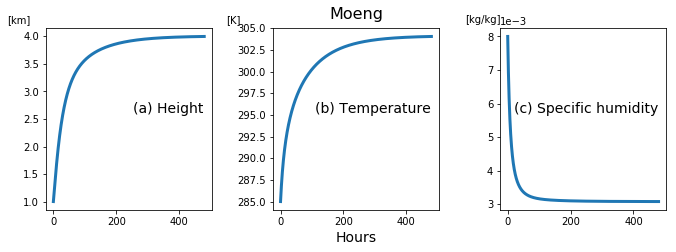

In [6]:
plot_profile(Xtime, height_M, T_M, Q_M, 'Moeng')

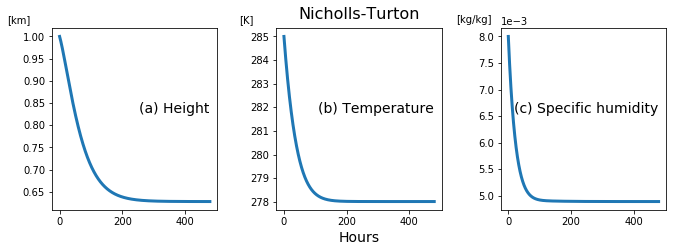

In [7]:
plot_profile(Xtime, height_NT, T_NT, Q_NT, 'Nicholls-Turton')

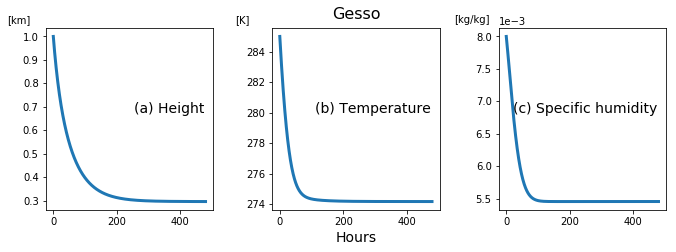

In [8]:
plot_profile(Xtime, height_G, T_G, Q_G, 'Gesso')

In [9]:
def flux_prof(z, Tflux, ETflux, height_NT):
    return Tflux + (ETflux - Tflux)*(z/height_NT)

def buoyancy_flux(T_NT, Q_NT, height_NT, T0, Q0, P0, Qft, U, Cdrag, lev=100):
    
    z = np.linspace(0, height_NT, lev)
    # flux profiles
    dT_NT = T_ft(height_NT, gamma) - T_NT
    Tflux = U*Cdrag*(T0 - T_NT)
    ETflux = -0.23*Tflux
    Qflux = U*Cdrag*(Q0 - Q_NT)
    We = -1*ETflux/dT_NT
    EQflux = -1*We*(Qft - Q_NT)
    Tprof = flux_prof(z, Tflux, ETflux, height_NT)
    Qprof = flux_prof(z, Qflux, EQflux, height_NT)
    # A, B
    Aw = np.empty(lev)
    Bw = np.empty(lev)
    P_NT = hydrostat_P(z, P0, height0=8000)
    for i, P in enumerate(P_NT):
        Aw[i], Bw[i], _ = tf.calc_ABcoeffs(T_NT, Q_NT, P/10)
    return Aw*Tprof + Bw*Qprof, z

In [10]:
Fb_NT, z = buoyancy_flux(T_NT[-1], Q_NT[-1], height_NT[-1], T0, Q0, P0, Qft, U, Cdrag, lev=100)

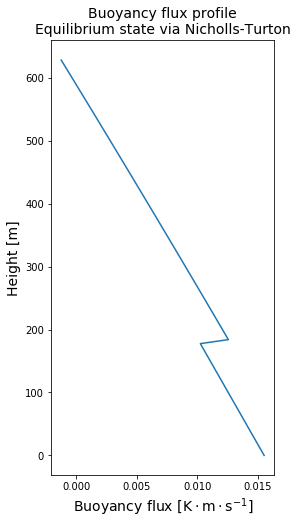

In [11]:
fig = plt.figure(figsize=(4, 8))
ax = fig.gca()
ax.set_title('Buoyancy flux profile\nEquilibrium state via Nicholls-Turton', fontsize=14)
ax.set_xlabel('Buoyancy flux [$\mathsf{K\cdot m\cdot s^{-1}}$]', fontsize=14)
ax.set_ylabel('Height [m]', fontsize=14)
ax.plot(Fb_NT, z)